In [1]:
import numpy as np
import numpy.linalg as la
import pandas as pd
import geopandas as gpd
from tqdm.notebook import tqdm

import osmnx as ox
import momepy
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import alphashape
from pyproj import Proj, Geod
import ast
import matplotlib.font_manager as font_manager
import datetime as dt


fontsize = 20
# fontsize_ax_ticks = 25
# fontsize_legend = 25
figsize = (15, 10)
font = 'Times New Roman'

data_path = '../../data/'  
polygon_road_network = gpd.read_file(data_path + 'network/QGIS_Project/referentiel-comptages-edit.shp')
paris_districts = gpd.read_file(data_path + 'districts_paris.geojson')
df_car_detectors = gpd.read_file(data_path + 'all_car_detectors.geojson')

## Goal of this notebook

The goal of this notebook is to optimize the matching process between the detector network and the "main roads" of OpenStreetMap. 

In [2]:
def line_length_in_meters(line_string):
    # Define a UTM projection for the zone containing your coordinates
    utm_zone = 31  # Assuming you are in Paris, which falls in UTM zone 31 for example
    proj = Proj(proj='utm', zone=utm_zone, ellps='WGS84')

    # Extract coordinates from the LineString
    coordinates = list(line_string.coords)

    # Transform the coordinates to UTM projection
    utm_coordinates = [proj(lon, lat) for lon, lat in coordinates]

    # Compute the distance between consecutive points in meters
    total_length = 0
    geod = Geod(ellps='WGS84')
    for i in range(len(utm_coordinates) - 1):
        lon1, lat1 = utm_coordinates[i]
        lon2, lat2 = utm_coordinates[i + 1]
        distance_meters = geod.inv(lon1, lat1, lon2, lat2)[-1]  # Use [-1] to get distance

        # Handle case of very small distances
        if np.isnan(distance_meters):
            dx = lon2 - lon1
            dy = lat2 - lat1
            distance_meters = np.sqrt(dx**2 + dy**2)
        total_length += distance_meters

    return total_length

def is_na_list(lst):
    return lst is None or len(lst) == 0 or all(pd.isna(x) for x in lst)

def parse_and_average_lanes(lanes_str):
    if isinstance(lanes_str, list):
        if is_na_list(lanes_str):
            return np.nan
        else: 
            return sum(map(int, lanes_str)) / len(lanes_str)
    else:
        if pd.isna(lanes_str):  # Check if input is NaN
            return np.nan  # Return NaN if input is NaN
    try:
        # Attempt to parse the string as a list
        lanes_list = ast.literal_eval(lanes_str)
        if isinstance(lanes_list, list):
            # If it's a list, calculate the average of list elements
            return sum(map(int, lanes_list)) / len(lanes_list)
        else:
            # If it's a single integer, return it as is
            return int(lanes_list)
    except (SyntaxError, ValueError):
        # If parsing fails or the lanes_str is not a list, parse as single integer
        return int(lanes_str)

def approximate_number_of_lanes(df_matched):
    df_matched_with_lanes_approximated = df_matched.copy()
    average_lanes_per_highway = df_matched.groupby('highway')['lanes_mapped'].mean()
    for index, row in df_matched_with_lanes_approximated.iterrows():
        if pd.isna(row['lanes_mapped']):
            df_matched_with_lanes_approximated.at[index, 'lanes_mapped'] = average_lanes_per_highway[row['highway']]
    return df_matched_with_lanes_approximated

This notebook matches the links of the Paris counting network with the links of an OSM network:
- Load [OpenStreetMap network](https://www.openstreetmap.org/#map=7/51.330/10.453)
- Load [detector network](https://opendata.paris.fr/explore/dataset/referentiel-comptages-routiers/information/)
- Perform matching by angle and centroid


## Load networks

In [3]:
# perform it for years 2013 - 2024. For some reason, one cannot retrieve detector data from OSM from before 2013.
year = 2013

output_path = "output/detectors_matched_2_osm_01_" + str(year)

In [4]:
# get OSM dataframe
alpha_shape = alphashape.alphashape(polygon_road_network, 435)
coordinates = list(alpha_shape.exterior[0].coords)
polygon = Polygon(coordinates)
x_coords, y_coords = zip(*coordinates)

overpass_settings = '[out:json][timeout:90][date:"' + str(year) + '-01-01T00:00:00Z"]'
print(overpass_settings)
ox.settings.overpass_settings = overpass_settings
ox.settings.log_console = True
G_road_network = ox.graph_from_polygon(
    polygon, simplify=True, network_type="drive")
nodes_osm, df_osm = momepy.nx_to_gdf(G_road_network, points=True, lines=True)
df_osm['osm_id'] = range(1, len(df_osm) + 1)

[out:json][timeout:90][date:"2013-01-01T00:00:00Z"]


/var/folders/m_/fjnjc1sn0ggc7z_2y7n27xfh0000gn/T/ipykernel_5942/3004573801.py:13: UserWarning: Approach is not set. Defaulting to 'primal'.
  nodes_osm, df_osm = momepy.nx_to_gdf(G_road_network, points=True, lines=True)


In [5]:
type(df_osm.iloc[0,:]['highway'])

str

In [6]:
unique_values = df_osm['highway'].astype(str).unique()
print(unique_values)

['primary' 'residential' 'tertiary' 'secondary' 'unclassified'
 "['residential', 'unclassified']" 'primary_link' 'trunk_link'
 "['tertiary', 'unclassified']" "['unclassified', 'residential']"
 'secondary_link' "['primary', 'primary_link']" 'living_street' 'trunk'
 "['living_street', 'residential']" 'road' "['secondary', 'primary']"
 'crossing' 'motorway_link' "['residential', 'road']" 'tertiary_link']


In [7]:
df_osm.drop(columns=['width', 'bridge', 'tunnel', 'junction', 'access', 'ref'])

,osmid,oneway,name,highway,reversed,length,geometry,maxspeed,lanes,node_start,node_end,osm_id
0,85735956,True,Boulevard Davout,primary,False,105.663,None,NaN,NaN,0,6175,1
1,4039936,False,Rue Louis Ganne,residential,False,9.897,"LINESTRING (2.40876 48.86333, 2.40882 48.86333...",NaN,NaN,0,8302,2
2,4039102,True,Rue de Buzenval,residential,False,130.239,None,NaN,NaN,1,3576,3
3,19876783,False,Rue de Buzenval,residential,False,107.950,None,30,NaN,1,3579,4
4,54830382,False,Rue d'Avron,tertiary,False,62.932,None,NaN,NaN,1,5936,5
...,...,...,...,...,...,...,...,...,...,...,...,...
17544,83261047,True,Boulevard Lefebvre,primary,False,5.615,None,NaN,2,8820,343,17545
17545,21804838,True,Rue Petit,residential,False,44.728,None,NaN,NaN,8821,8822,17546
17546,198055406,False,NaN,residential,False,165.310,"LINESTRING (2.38197 48.88483, 2.38229 48.88429...",NaN,NaN,8821,8822,17547
17547,21804838,True,Rue Petit,residential,False,52.991,"LINESTRING (2.38258 48.88488, 2.38290 48.88490...",NaN,NaN,8822,2290,17548


In [8]:
# Filter osm network for higher order roads
df_osm_hor = df_osm[
    df_osm["highway"].str.contains("motorway") |
    df_osm["highway"].str.contains("trunk") |
    df_osm["highway"].str.contains("primary") |
    df_osm["highway"].str.contains("secondary") |
    df_osm["highway"].str.contains("tertiary") 
]
df_osm_hor = df_osm_hor[df_osm_hor['geometry'].notnull()]

In [9]:
# process car detectors -> only consider those inside polygon

boundary_gdf = gpd.GeoDataFrame(
    geometry=[polygon], crs=df_car_detectors.crs)
df_car_detectors_without_dupl = df_car_detectors.drop_duplicates(
    subset='iu_ac', keep='first')
car_detectors_within_boundary = gpd.sjoin(
    df_car_detectors_without_dupl, boundary_gdf, op='within')
df_detectors = car_detectors_within_boundary.copy()

/Users/elenanatterer/anaconda3/envs/Paris_Analysis/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [10]:
# Configure matching process

# Trade-off between scoring angle difference and centroid distance. alpha = 0.2 seemed to get the best matching. Keep in mind that we normalize the absolute difference of centroid 
# distance and angle difference is done in the score computation. 
alpha = 0.8

# Maximum centroid distance between two candidates
maximum_distance = 50

# Maximum angle difference between two candidates
maximum_angle = 15 * np.pi / 180.0

## Plot data

In [11]:
# fig, ax = plt.subplots()
# df_detectors.plot(ax=ax)

In [12]:
# fig, ax = plt.subplots()
# df_osm.plot(ax=ax)

In [13]:
# fig, ax = plt.subplots()
# df_osm_hor.plot(ax=ax)

## Matching

In [14]:
# Calculate centroids
detector_centroids = np.vstack([
    df_detectors["geometry"].centroid.x, df_detectors["geometry"].centroid.y]).T

osm_centroids = np.vstack([
    df_osm_hor["geometry"].centroid.x, df_osm_hor["geometry"].centroid.y]).T

/var/folders/m_/fjnjc1sn0ggc7z_2y7n27xfh0000gn/T/ipykernel_5942/3904791298.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_detectors["geometry"].centroid.x, df_detectors["geometry"].centroid.y]).T
/var/folders/m_/fjnjc1sn0ggc7z_2y7n27xfh0000gn/T/ipykernel_5942/3904791298.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_osm_hor["geometry"].centroid.x, df_osm_hor["geometry"].centroid.y]).T


In [15]:
# Calculate orientation

def angle(geometry):
    coordinates = np.array(geometry.xy).T
    return np.arctan2(coordinates[-1, 1] - coordinates[0, 1], coordinates[-1, 0] - coordinates[0, 0])
    
detector_angles = df_detectors["geometry"].apply(angle).values
osm_angles = df_osm_hor["geometry"].apply(angle).values

In [16]:
# Calculate n-to-m distances
centroid_distances = np.zeros((len(detector_centroids), len(osm_centroids)))
angle_distances = np.zeros((len(detector_centroids), len(osm_centroids)))

In [17]:
for k in tqdm(range(len(detector_centroids))):
    centroid_distances[k,:] = la.norm(detector_centroids[k] - osm_centroids, axis = 1)
    angle_distances[k,:] = np.abs(detector_angles[k] - osm_angles)

angle_distances[angle_distances < 0.0] += 2.0 * np.pi

  0%|          | 0/2719 [00:00<?, ?it/s]

In [18]:
# Prepare scoring / matching
normalization_variable = angle_distances.mean()/centroid_distances.mean()

scores = alpha * centroid_distances + (1-alpha) * (1/normalization_variable) * angle_distances
# scores = alpha * centroid_distances + (1-alpha) * 0.1 * angle_distances

# Deactivate improbable matchings
scores[centroid_distances > maximum_distance] = np.inf
scores[angle_distances > maximum_angle] = np.inf

In [19]:
1/normalization_variable

0.025535671118658232

In [20]:
# Matching process
matchings = []
matched_scores = []

# The idea is relatively simple:
# - Find the matching with the smallest score among those with a finite value
# - Note down the matching, and set all matching containing the two links to Inf
# - Continue until no scores with finite value are left

current = np.count_nonzero(~np.isfinite(scores))

with tqdm(total = np.prod(scores.shape) - current) as progress:
    while np.count_nonzero(np.isfinite(scores)) > 0:
        # Find best score and note down
        index = np.unravel_index(np.argmin(scores), scores.shape)
        matched_scores.append(scores[index])

        # Set both invlved links to Inf
        scores[index[0], :] = np.inf
        scores[:, index[1]] = np.inf
        
        # Manage progress plotting
        update = np.count_nonzero(~np.isfinite(scores))
        
        if update > current:
            progress.update(update - current)
            current = update

        matchings.append(index)
        
matchings = np.array(matchings) # The matchings themselves (index reference, index matsim)
matched_scores = np.array(matched_scores) # The scores of the matchings

  0%|          | 0/866592 [00:00<?, ?it/s]

## Output

In [21]:
# Construct a data set containing all matching information
df_matching = pd.DataFrame({
    "iu_ac": df_detectors.iloc[matchings[:, 0]]["iu_ac"].values,
    "geometry_detector": df_detectors.iloc[matchings[:, 0]]["geometry"].values,
    "osm_id": df_osm_hor.iloc[matchings[:,1]]["osm_id"].values,
    "lanes": df_osm_hor.iloc[matchings[:, 1]]["lanes"].values,
    "highway": df_osm_hor.iloc[matchings[:, 1]]["highway"].values,
    "oneway": df_osm_hor.iloc[matchings[:, 1]]["oneway"].values,
    "length_mapped_osm_street": df_osm_hor.iloc[matchings[:, 1]]["length"].values,
    "score": matched_scores,
    "date_start": df_detectors.iloc[matchings[:,0]]["date_debut"].values,
    "date_end": df_detectors.iloc[matchings[:,0]]["date_fin"].values,
})
df_matching = df_matching.sort_values(by='iu_ac')

In [22]:
df_matching['length_detector_street'] = df_matching['geometry_detector'].apply(lambda x: line_length_in_meters(x))
df_matching['lanes_mapped'] = df_matching['lanes'].apply(parse_and_average_lanes)
df_matched_with_lanes_approximated = approximate_number_of_lanes(df_matching)

In [23]:
# df_matched_with_lanes_approximated['lanes_mapped']


nan_count = df_matched_with_lanes_approximated['lanes_mapped'].isna().sum()
print("Number of NaN values in 'lanes_mapped' column:", nan_count)



Number of NaN values in 'lanes_mapped' column: 66


In [41]:
if year == 2013:
    # number of lanes are missing for highways of type "primary_link", "secondary_link", "trunk_link"
    
    number_of_lanes_primary_link = df_matched_with_lanes_approximated[df_matched_with_lanes_approximated['highway'] == 'primary']['lanes_mapped'].mean()
    number_of_lanes_secondary_link = df_matched_with_lanes_approximated[df_matched_with_lanes_approximated['highway'] == 'secondary']['lanes_mapped'].mean()
    number_of_lanes_tertiary_link = df_matched_with_lanes_approximated[df_matched_with_lanes_approximated['highway'] == 'tertiary']['lanes_mapped'].mean()
    number_of_lanes_trunk_link = df_matched_with_lanes_approximated[df_matched_with_lanes_approximated['highway'] == 'trunk']['lanes_mapped'].mean()
    print(number_of_lanes_primary_link, number_of_lanes_secondary_link, number_of_lanes_trunk_link)
    
    df_matched_with_lanes_approximated.loc[df_matched_with_lanes_approximated['highway'] == 'primary_link', 'lanes_mapped'] = number_of_lanes_primary_link
    df_matched_with_lanes_approximated.loc[df_matched_with_lanes_approximated['highway'] == 'secondary_link', 'lanes_mapped'] = number_of_lanes_secondary_link
    df_matched_with_lanes_approximated.loc[df_matched_with_lanes_approximated['highway'] == 'tertiary_link', 'lanes_mapped'] = number_of_lanes_tertiary_link
    df_matched_with_lanes_approximated.loc[df_matched_with_lanes_approximated['highway'] == 'trunk_link', 'lanes_mapped'] = number_of_lanes_trunk_link



3.115384615384615 2.4375 4.333333333333333


In [42]:
nan_count = df_matched_with_lanes_approximated['lanes_mapped'].isna().sum()
print("Number of NaN values in 'lanes_mapped' column:", nan_count)

Number of NaN values in 'lanes_mapped' column: 0


In [44]:
districts = gpd.read_file(data_path + 'districts_paris.geojson')

In [45]:
districts

,c_ar,surface,perimetre,geometry
0,1,1.824613e+06,6054.936862,"POLYGON ((2.32801 48.86992, 2.32997 48.86851, ..."
1,2,9.911537e+05,4554.104360,"POLYGON ((2.35152 48.86443, 2.35095 48.86341, ..."
2,3,1.170883e+06,4519.263648,"POLYGON ((2.36383 48.86750, 2.36389 48.86747, ..."
3,4,1.600586e+06,5420.908434,"POLYGON ((2.36851 48.85573, 2.36900 48.85374, ..."
4,5,2.539375e+06,6239.195396,"POLYGON ((2.36443 48.84614, 2.36484 48.84584, ..."
5,6,2.153096e+06,6483.686786,"POLYGON ((2.34459 48.85405, 2.34428 48.85375, ..."
6,7,4.090057e+06,8099.424883,"POLYGON ((2.32090 48.86306, 2.32094 48.86305, ..."
7,8,3.880036e+06,7880.533268,"POLYGON ((2.32584 48.86956, 2.32569 48.86954, ..."
8,9,2.178303e+06,6471.588290,"POLYGON ((2.33978 48.88203, 2.33982 48.88202, ..."
9,10,2.891739e+06,6739.375055,"POLYGON ((2.36469 48.88437, 2.36485 48.88436, ..."


In [46]:
p = 0.9
percentile = df_matched_with_lanes_approximated['score'].quantile(p)

# # filter detectors for date_debut and date_fin
start_date = pd.Timestamp('2023-01-01 00:00:00+0000', tz='UTC')
df_detectors_2023 = df_detectors[(df_detectors['date_debut'] <= start_date) & (df_detectors['date_fin'] >= start_date)]
df_matching_best = df_matched_with_lanes_approximated[df_matched_with_lanes_approximated['score'] < percentile]
gdf_matched = gpd.GeoDataFrame(df_matching_best, geometry='geometry_detector')

In [47]:
zone1 = districts[(districts['c_ar'] == 1) | (districts['c_ar'] == 2) | (districts['c_ar'] == 3) | (districts['c_ar'] == 4)]
zone2 = districts[(districts['c_ar'] == 5) | (districts['c_ar'] == 6) | (districts['c_ar'] == 7)]
zone_1_boundary = zone1.geometry.unary_union
zone_2_boundary = zone2.geometry.unary_union

gdf_matched_intersect_zone_1_boundary = gdf_matched[gdf_matched.intersects(zone_1_boundary)]
df_osm_hor_intersect_zone_1_boundary = df_osm_hor[df_osm_hor.intersects(zone_1_boundary)]
df_detectors_intersect_zone_1_boundary = df_detectors_2023[df_detectors_2023.intersects(zone_1_boundary)]

gdf_matched_intersect_zone_2_boundary = gdf_matched[gdf_matched.intersects(zone_2_boundary)]
df_osm_hor_intersect_zone_2_boundary = df_osm_hor[df_osm_hor.intersects(zone_2_boundary)]
df_detectors_intersect_zone_2_boundary = df_detectors_2023[df_detectors_2023.intersects(zone_2_boundary)]
df_osm_intersect_zone_1_boundary = df_osm[df_osm.intersects(zone_1_boundary)]
df_osm_intersect_zone_2_boundary = df_osm[df_osm.intersects(zone_2_boundary)]

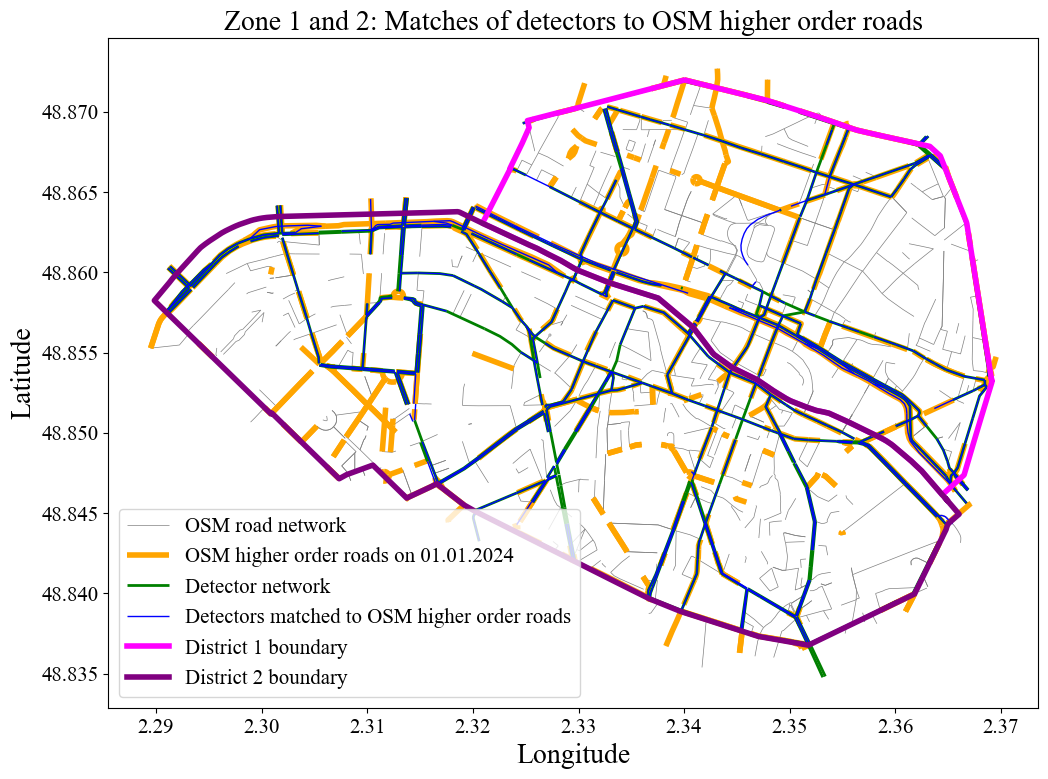

In [48]:
fig, ax = plt.subplots(figsize=(12, 10))
df_osm_intersect_zone_1_boundary.plot(ax=ax, linewidth = 0.5, color = "grey", label = "OSM road network")
df_osm_hor_intersect_zone_1_boundary.plot(ax=ax, color = 'orange', linewidth = 4, label = "OSM higher order roads on 01.01.2024")
df_detectors_intersect_zone_1_boundary.plot(ax=ax, linewidth=2, color = "green", label = "Detector network")
gdf_matched_intersect_zone_1_boundary.plot(ax=ax, color = 'blue', linewidth=1, label = "Detectors matched to OSM higher order roads")

df_osm_intersect_zone_2_boundary.plot(ax=ax, linewidth = 0.5, color = "grey")
df_osm_hor_intersect_zone_2_boundary.plot(ax=ax, color = 'orange', linewidth = 4)
df_detectors_intersect_zone_2_boundary.plot(ax=ax, linewidth=2, color = "green")
gdf_matched_intersect_zone_2_boundary.plot(ax=ax, color = 'blue', linewidth=1)

exterior_x, exterior_y = zone_1_boundary.exterior.xy
plt.plot(exterior_x, exterior_y, color = 'magenta', linewidth = 4, label = "District 1 boundary")

exterior_x_zone_2, exterior_y_zone_2 = zone_2_boundary.exterior.xy
plt.plot(exterior_x_zone_2, exterior_y_zone_2, color = 'purple', linewidth = 4, label = "District 2 boundary")

plt.xlabel("Longitude", font = font, fontsize = fontsize)
plt.ylabel("Latitude", font = font, fontsize = fontsize)
plt.title("Zone 1 and 2: Matches of detectors to OSM higher order roads", font = font, fontsize = fontsize)
plt.xticks(font = font, fontsize = 15)
plt.yticks(font = font, fontsize = 15)
font_legend = font_manager.FontProperties(family=font, style='normal', size=15)
plt.legend(loc='lower left', prop = font_legend)
plt.savefig("results/zone_1_matched.pdf", dpi=1000, bbox_inches='tight')

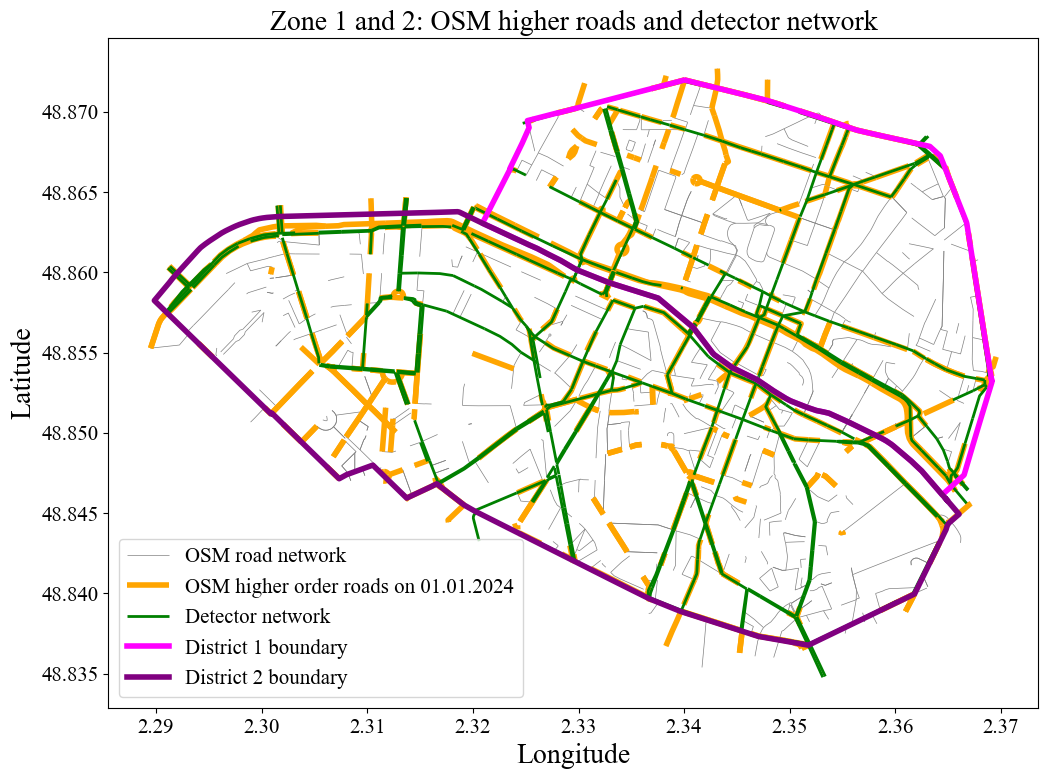

In [49]:
fig, ax = plt.subplots(figsize=(12, 10))
df_osm_intersect_zone_1_boundary.plot(ax=ax, linewidth = 0.5, color = "grey", label = "OSM road network")
df_osm_hor_intersect_zone_1_boundary.plot(ax=ax, color = 'orange', linewidth = 4, label = "OSM higher order roads on 01.01.2024")
df_detectors_intersect_zone_1_boundary.plot(ax=ax, linewidth=2, color = "green", label = "Detector network")

df_osm_intersect_zone_2_boundary.plot(ax=ax, linewidth = 0.5, color = "grey")
df_osm_hor_intersect_zone_2_boundary.plot(ax=ax, color = 'orange', linewidth = 4)
df_detectors_intersect_zone_2_boundary.plot(ax=ax, linewidth=2, color = "green")

exterior_x, exterior_y = zone_1_boundary.exterior.xy
plt.plot(exterior_x, exterior_y, color = 'magenta', linewidth = 4, label = "District 1 boundary")

exterior_x_zone_2, exterior_y_zone_2 = zone_2_boundary.exterior.xy
plt.plot(exterior_x_zone_2, exterior_y_zone_2, color = 'purple', linewidth = 4, label = "District 2 boundary")

plt.xlabel("Longitude", font = font, fontsize = fontsize)
plt.ylabel("Latitude", font = font, fontsize = fontsize)
plt.title("Zone 1 and 2: OSM higher roads and detector network", font = font, fontsize = fontsize)
plt.xticks(font = font, fontsize = 15)
plt.yticks(font = font, fontsize = 15)
font_legend = font_manager.FontProperties(family=font, style='normal', size=15)
plt.legend(loc='lower left', prop = font_legend)
plt.savefig("results/zone_1_osm_hor_and_dets.pdf", dpi=1000, bbox_inches='tight')

In [50]:
gdf_matched_intersect_zone_1_boundary

,iu_ac,geometry_detector,osm_id,lanes,highway,oneway,length_mapped_osm_street,score,date_start,date_end,length_detector_street,lanes_mapped
1639,1,"LINESTRING (2.33342 48.86003, 2.33506 48.85965)",4809,2,primary,True,1290.256,0.001095,1996-10-03 02:00:00,2023-01-01 01:00:00,127.877045,2.000000
738,10,"LINESTRING (2.34947 48.85648, 2.35059 48.85606)",1169,NaN,primary,True,143.586,0.000276,1996-10-03 02:00:00,2023-01-01 01:00:00,94.716807,3.115385
1391,1007,"LINESTRING (2.33327 48.86007, 2.33249 48.85877...",4370,NaN,secondary,False,153.382,0.000709,1996-10-03 02:00:00,2023-01-01 01:00:00,179.978912,2.437500
812,11,"LINESTRING (2.35059 48.85606, 2.35269 48.85524)",4423,NaN,primary,False,146.062,0.000313,1996-10-03 02:00:00,2023-01-01 01:00:00,178.644058,3.115385
2286,110,"LINESTRING (2.34679 48.85941, 2.34642 48.85912)",290,NaN,tertiary,True,104.287,0.006029,2005-01-01 01:00:00,2019-06-01 02:00:00,42.116605,2.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2446,81,"LINESTRING (2.34255 48.85846, 2.34391 48.85992)",4234,NaN,tertiary,False,68.425,0.008554,1996-10-03 02:00:00,2023-01-01 01:00:00,190.414951,2.000000
1998,82,"LINESTRING (2.34240 48.85849, 2.34190 48.85787)",4382,NaN,secondary,False,104.104,0.003059,1996-10-03 02:00:00,2023-01-01 01:00:00,78.813600,2.437500
2319,83,"LINESTRING (2.34137 48.85722, 2.34103 48.85683)",12314,NaN,tertiary,False,66.165,0.006352,1996-10-03 02:00:00,2023-01-01 01:00:00,49.750142,2.000000
842,84,"LINESTRING (2.34103 48.85683, 2.34036 48.85621)",15937,NaN,secondary,False,105.668,0.000330,1996-10-03 02:00:00,2023-01-01 01:00:00,85.118129,2.437500


In [51]:
def get_length_in_lane_km(gdf):
    length_in_lane_km = 0

    for idx, row in gdf.iterrows():
        length = row['length_detector_street']
        lanes = row['lanes_mapped']
        if pd.isna(lanes):
            continue
        if pd.isna(length):
            continue
        length_in_lane_km += length * lanes / 1000
        # print(length_in_lane_km)
    return length_in_lane_km

length_in_lane_km_zone_1 = get_length_in_lane_km(gdf_matched_intersect_zone_1_boundary)
length_in_lane_km_zone_2 = get_length_in_lane_km(gdf_matched_intersect_zone_2_boundary)
    
print(length_in_lane_km_zone_1)
print(length_in_lane_km_zone_2)    

80.11361205504146
112.49674431668306


In [52]:
gdf_matched_intersect_zone_2_boundary

,iu_ac,geometry_detector,osm_id,lanes,highway,oneway,length_mapped_osm_street,score,date_start,date_end,length_detector_street,lanes_mapped
1570,100,"LINESTRING (2.34994 48.84888, 2.34916 48.84992)",978,NaN,secondary,True,53.408,0.000931,1996-10-03 02:00:00,2023-01-01 01:00:00,128.196599,2.4375
1391,1007,"LINESTRING (2.33327 48.86007, 2.33249 48.85877...",4370,NaN,secondary,False,153.382,0.000709,1996-10-03 02:00:00,2023-01-01 01:00:00,179.978912,2.4375
1482,101,"LINESTRING (2.34916 48.84992, 2.34772 48.85162...",3717,NaN,secondary,True,47.212,0.000811,1996-10-03 02:00:00,2023-01-01 01:00:00,307.729822,2.4375
2039,118,"LINESTRING (2.33311 48.85264, 2.33330 48.85343...",3077,NaN,tertiary,False,39.920,0.003443,1996-10-03 02:00:00,2023-01-01 01:00:00,129.581211,2.0000
751,1225,"LINESTRING (2.35444 48.84947, 2.35471 48.84948...",15859,NaN,secondary,True,67.723,0.000285,1996-10-03 02:00:00,2023-01-01 01:00:00,114.367442,2.4375
...,...,...,...,...,...,...,...,...,...,...,...,...
2118,95,"LINESTRING (2.33395 48.85550, 2.33535 48.85776)",12404,NaN,tertiary,True,79.829,0.004226,1996-10-03 02:00:00,2023-01-01 01:00:00,271.927946,2.0000
2337,96,"LINESTRING (2.33315 48.85379, 2.33300 48.85374...",3844,NaN,tertiary,False,34.122,0.006641,1996-10-03 02:00:00,2023-01-01 01:00:00,82.105056,2.0000
260,97,"LINESTRING (2.33196 48.85245, 2.33311 48.85264)",3056,NaN,tertiary,True,93.015,0.000103,1996-10-03 02:00:00,2023-01-01 01:00:00,86.888454,2.0000
1549,98,"LINESTRING (2.33311 48.85264, 2.33366 48.85266...",3064,NaN,tertiary,True,93.774,0.000908,1996-10-03 02:00:00,2023-01-01 01:00:00,220.919547,2.0000


We find, for 01.01.2024:

Z1: 78.66487745107128
Z2: 121.94722011749302

# Plot

In [53]:
# fig, ax = plt.subplots(figsize=(12, 10))
# # df_matching_best.plot(ax=ax, color = 'magenta', linewidth=1, label = "Matches")
# df_osm_hor.plot(ax=ax, color = 'orange', linewidth = 4, label = "OSM higher order roads")
# df_detectors.plot(ax=ax, linewidth=1, color = "green", label = "Detectors")

# plt.xlabel("Longitude", font = font, fontsize = fontsize)
# plt.ylabel("Latitude", font = font, fontsize = fontsize)
# plt.title("Paris - OSM higher order roads and detector matches", font = font, fontsize = fontsize)

# plt.xticks(font = font, fontsize = fontsize)
# plt.yticks(font = font, fontsize = fontsize)
# font_legend = font_manager.FontProperties(family=font, style='normal', size=15)
# plt.legend(loc='upper left', prop = font_legend)

# plt.savefig("results/osm_hor_and_detectors.pdf", dpi=1000)

In [54]:
# save the results

df_matching_best.to_csv(output_path + "_best_matches.csv", sep=";", index=False)
df_matched_with_lanes_approximated.to_csv(output_path + ".csv", sep=";", index=False)

In [55]:
# df_comparison = df_detectors.copy()
# df_comparison = pd.merge(df_comparison, df_matching)
# df_comparison.to_file("output/detectors_matched_2_osm.geojson", driver = 'GeoJSON')

In [56]:
# osm_matched_2_detectors = df_osm_hor.copy()
# osm_matched_2_detectors = pd.merge(osm_matched_2_detectors, df_matching)
# osm_matched_2_detectors.to_file(
#     "output/osm_matched_2_detectors.geojson", driver='GeoJSON')